In [1]:
import pandas as pd
import numpy as np
from os.path import basename
from glob import glob
import h5py
import scipy.stats as ss

import matplotlib.pyplot as plt
from plotnine import *
from IPython.display import display, Markdown

import sys
sys.path.insert(0, '../CODE/')
from importlib import reload
import visualization_utils
reload(visualization_utils)
from visualization_utils import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
def resp_ratio(x):
    return sum(x == 1) / len(x)

# Human HEK293 10-fold-cv performance

In [3]:
out_dir = '../OUTPUT/human_80tfs_hek293/'

pred_df = pd.read_csv(out_dir + 'preds.csv.gz')
rr_df = pred_df.groupby('tf')['label'].agg(resp_ratio).reset_index()

In [4]:
stats_df = pd.read_csv(out_dir + 'stats.csv.gz')
stats_df = stats_df.merge(rr_df, on='tf')

stats_df

,cv,tf,auroc,auprc,label
0,0,ENSG00000085644,0.851677,0.152857,0.025657
1,0,ENSG00000099326,0.817902,0.200254,0.060500
2,0,ENSG00000169957,0.709866,0.322958,0.180815
3,0,ENSG00000178229,0.813407,0.168333,0.048675
4,0,ENSG00000182986,0.854468,0.044927,0.006230
...,...,...,...,...,...
75,9,ENSG00000128610,0.791508,0.227535,0.071956
76,9,ENSG00000147124,0.877274,0.118946,0.013937
77,9,ENSG00000173041,0.721389,0.174357,0.074966
78,9,ENSG00000182318,0.782631,0.150956,0.053373


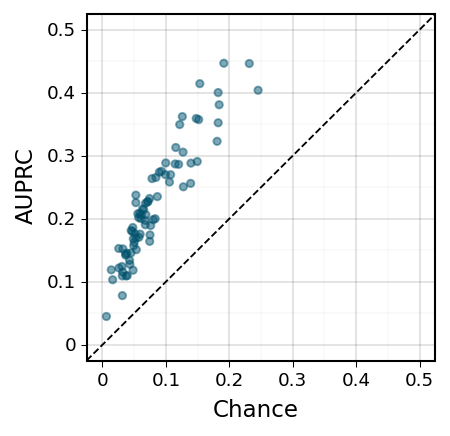

<ggplot: (2940522030193)>

In [5]:
(
    ggplot(stats_df, aes(x='label', y='auprc'))
    + geom_point(color=COLORS['dark_blue'], alpha=.5)
    + geom_abline(slope=1, intercept=0, linetype='dashed')
    + lims(x=[0, .5], y=[0, .5])
    + labs(x='Chance', y='AUPRC')
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150)
)

# SHAP

In [6]:
organism = 'human_hek293'
hek_dir = '../OUTPUT/human_80tfs_hek293/'
hek_tfs = np.loadtxt('../../Pert_Response_Modeling/RESOURCES/TF_list/Human_HEK293_TFs.txt', dtype=str)

hek_sss_df = pd.DataFrame()

for i, tf_chunk in enumerate(np.array_split(hek_tfs, 4)):
    print('Working on TF chunk {}, n={}'.format(i, len(tf_chunk)))
    
    hek_sss_subdf = calculate_resp_and_unresp_signed_shap_sum(hek_dir, organism=organism, tfs=tf_chunk)
    hek_sss_df = hek_sss_df.append(hek_sss_subdf)

hek_sss_df.to_csv('../OUTPUT/human_80tfs_hek293/signed_shap_sum.csv.gz')

Working on TF chunk 0, n=20
Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 
Parsing signed shap values ...
Summing shap ...
Working on TF chunk 1, n=20
Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 
Parsing signed shap values ...
Summing shap ...
Working on TF chunk 2, n=20
Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 
Parsing signed shap values ...
Summing shap ...
Working on TF chunk 3, n=20
Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 
Parsing signed shap values ...
Summing shap 

In [6]:
hek_sss_df = pd.read_csv('../OUTPUT/human_80tfs_hek293/signed_shap_sum.csv.gz')

hek_sss_df = hek_sss_df.merge(stats_df[['tf', 'auprc']], on='tf', how='left')
hek_sss_df = calculate_shap_net_influence(hek_sss_df)

All TFs (n=80)


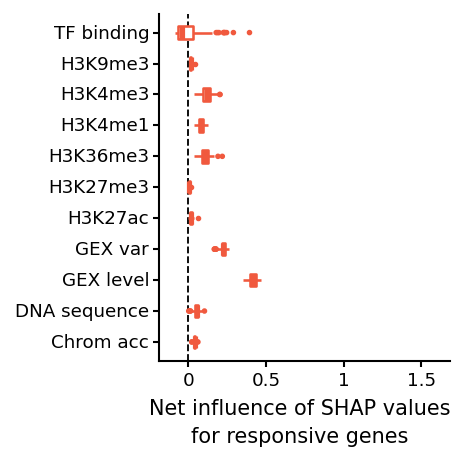

<ggplot: (-9223369096330737243)>

In [14]:
# Plot all models
plot_df = hek_sss_df[(hek_sss_df['label_name'] == 'Responsive')]
print('All TFs (n={})'.format(len(plot_df['tf'].unique())))

ax = (
    ggplot(plot_df, aes(x='feat_type_name', y='shap_diff'))
    + geom_hline(yintercept=0, linetype='dashed')
    + geom_boxplot(outlier_size=.5, size=.7, width=.4, color=COLORS['orange'])
#     + geom_jitter(height=0, width=.2, alpha=.2, color='blue')
    + coord_flip()
    + ylim(-.1, 1.6)
    + labs(x=None, y='Net influence of SHAP values\nfor responsive genes')
    + theme_classic()
    + theme(
        figure_size=(2.5, 3), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'),
        axis_title=element_text(size=10, lineheight=1.5))
)
display(ax)

TFs w/ AUPRC > 0.1 (n=78)


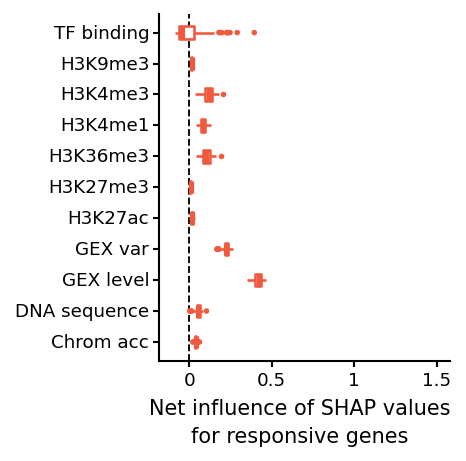

<ggplot: (-9223369096331077537)>

In [15]:
# Plot all models
plot_df = hek_sss_df[(hek_sss_df['auprc'] > 0.1) & (hek_sss_df['label_name'] == 'Responsive')]
print('TFs w/ AUPRC > 0.1 (n={})'.format(len(plot_df['tf'].unique())))

ax = (
    ggplot(plot_df, aes(x='feat_type_name', y='shap_diff'))
    + geom_hline(yintercept=0, linetype='dashed')
    + geom_boxplot(outlier_size=.5, size=.7, width=.4, color=COLORS['orange'])
#     + geom_jitter(height=0, width=.2, alpha=.2, color='blue')
    + coord_flip()
    + ylim(-.1, 1.5)
    + labs(x=None, y='Net influence of SHAP values\nfor responsive genes')
    + theme_classic()
    + theme(
        figure_size=(2.5, 3), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'),
        axis_title=element_text(size=10, lineheight=1.5))
)
display(ax)